In [59]:
import sys
from pathlib import Path

venti_src_path = Path('/u/duvel-d2/govorcin/NJ/ASC/GNSS/Venti/src')
sys.path.append(str(venti_src_path))

In [60]:
%load_ext autoreload
%autoreload 2

In [61]:
import os
os.environ['USE_PYGEOS'] = '0'

import warnings
warnings.filterwarnings("ignore")
from pathlib import Path
from datetime import datetime 

import numpy as np
import pandas as pd
import geopandas as gpd
from rasterio.crs import CRS
import contextily as cx
from matplotlib import pyplot as plt
from tqdm import tqdm

from venti.gnss.gps import UNR

In [62]:
# Setup
gnss_midas_pickle = 'unr_gnss_midas_2015_2024.pickle'
gnss_hector_pickle = 'unr_gnss_hector_2015_2024.pickle'

# AOI Extent with latitude and longitude:
#          [South North West East] 

aoi_snwe = [33, 45, -80, -70]  

# Time period 
start = '20150101'
end = '20250105'

# Download UNR GNSS sites
UNR timeseries solution reference: 

Blewitt, G., W. C. Hammond, and C. Kreemer (2018), Harnessing the GPS data explosion for interdisciplinary science, Eos, 99, https://doi.org/10.1029/2018EO104623.

In [63]:
# Initialize UNR class
# Source: http://geodesy.unr.edu/ 
gnss = UNR(output_dir='/u/duvel-d2/govorcin/NJ/ASC/GNSS/2015_2024')

In [64]:
# Load if it exists to skip re-processing
#gnss = gnss.load(gnss_midas_pickle)

Finish downloading: 0.63s duration
Number of GNSS sites: 1016


<Axes: >

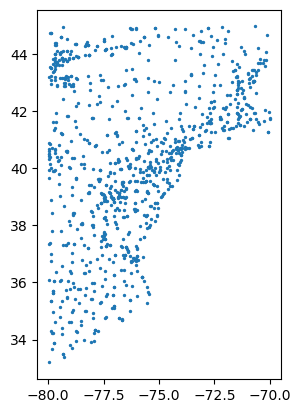

In [65]:
# find GNSS stations for defined aoi (CA)
gnss.read_station_list(snwe=aoi_snwe)

#Download timeseries
gnss.download_ts_files()

# Get offsets for the sites from UNR page
# URL: http://geodesy.unr.edu/NGLStationPages/steps.txt 
gnss.get_steps()

# Plot downloaded UNR sites
df_gnss = gpd.GeoDataFrame(gnss.gnss_df,
                           geometry = gpd.points_from_xy(gnss.gnss_df.lon,
                                                         gnss.gnss_df.lat),
                           crs=CRS.from_epsg(4326))
print(f'Number of GNSS sites: {df_gnss.shape[0]}')
df_gnss.plot(markersize=2)

# Filter sites

In [66]:
# Filter based on duration and time-span
# 1 Remove GNSS sites that stop recording before Jan 01, 2015 
#  before Sentinel1 acquisitions
end_date = datetime(2014, 1, 1)
# 2 Remove GNSS sites with timeseries duration less than 3 years
min_duration = 3 # yr 
flag = (gnss.gnss_df.end_date > end_date) & (gnss.gnss_df.duration > min_duration) 
print(f'Remove {np.sum(~flag)} sites with duration below {min_duration} yr and ending before {end_date.strftime("%Y%m%d")}')
gnss.gnss_df = gnss.gnss_df[flag]

Remove 268 sites with duration below 3 yr and ending before 20140101


In [67]:
# Refine the duration for the specified time period
new_duration = []
for _, df in gnss.gnss_df.iterrows():
    if df.start_date > datetime.strptime(start,'%Y%m%d'):
        start_date = df.start_date
    else:
        start_date = datetime.strptime(start,'%Y%m%d')

    if df.end_date < datetime.strptime(end,'%Y%m%d'):
        end_date = df.end_date
    else:
        end_date = datetime.strptime(end,'%Y%m%d') 
    new_duration.append((end_date - start_date) / pd.Timedelta('365.25 days'))

# new duration
new_duration = np.vstack(new_duration)
print(f'Remove {np.sum(new_duration < 3)} sites with duration below {min_duration} yr')
gnss.gnss_df = gnss.gnss_df[new_duration > 3]

Remove 80 sites with duration below 3 yr


In [68]:
## Get gap percentage for the period 2014 - 2024, with 1 day sampling
gnss.gnss_df['gap_percentage'] = [gnss._get_gap_percentage(site,
                                                           sampling_period=1,
                                                           start=start,
                                                           end=end) 
                                 for site in tqdm(gnss.gnss_df.site)]

100%|██████████| 668/668 [00:19<00:00, 33.68it/s]


In [69]:
gnss.gnss_df

,site,lat,lon,n,e,v,sn,se,sv,n_gaps,duration,start_date,end_date,ts_path,gap_percentage
670,AA01,43.672798,-71.486298,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.676933,2013-01-23,2024-09-27,nan,20.858393
674,AAM1,39.996899,-76.089905,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.834360,2010-11-27,2024-09-27,nan,24.412247
905,ACU5,41.743599,-70.886993,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.310745,2002-03-09,2020-06-30,nan,54.729360
906,ACU6,41.743301,-70.886597,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.342232,2004-02-21,2020-06-25,nan,55.986878
1006,AID1,39.321899,-76.503601,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.216975,2021-07-10,2024-09-27,nan,77.747403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22092,YOU6,43.231300,-78.969788,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.800137,1996-09-11,2020-06-30,nan,53.335156
22106,YRVA,37.226501,-76.478790,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.993155,2015-12-03,2021-11-30,nan,46.418808
22199,ZBW1,42.735699,-71.480408,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.319645,2003-06-04,2024-09-28,nan,5.549481
22200,ZDC1,39.101601,-77.542694,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.467487,2003-04-11,2024-09-28,nan,5.576818


(array([[-15.50308035,   5.90203854,   0.28015477]]),
 array([[0.18656619, 0.20925745, 0.64899767]]))

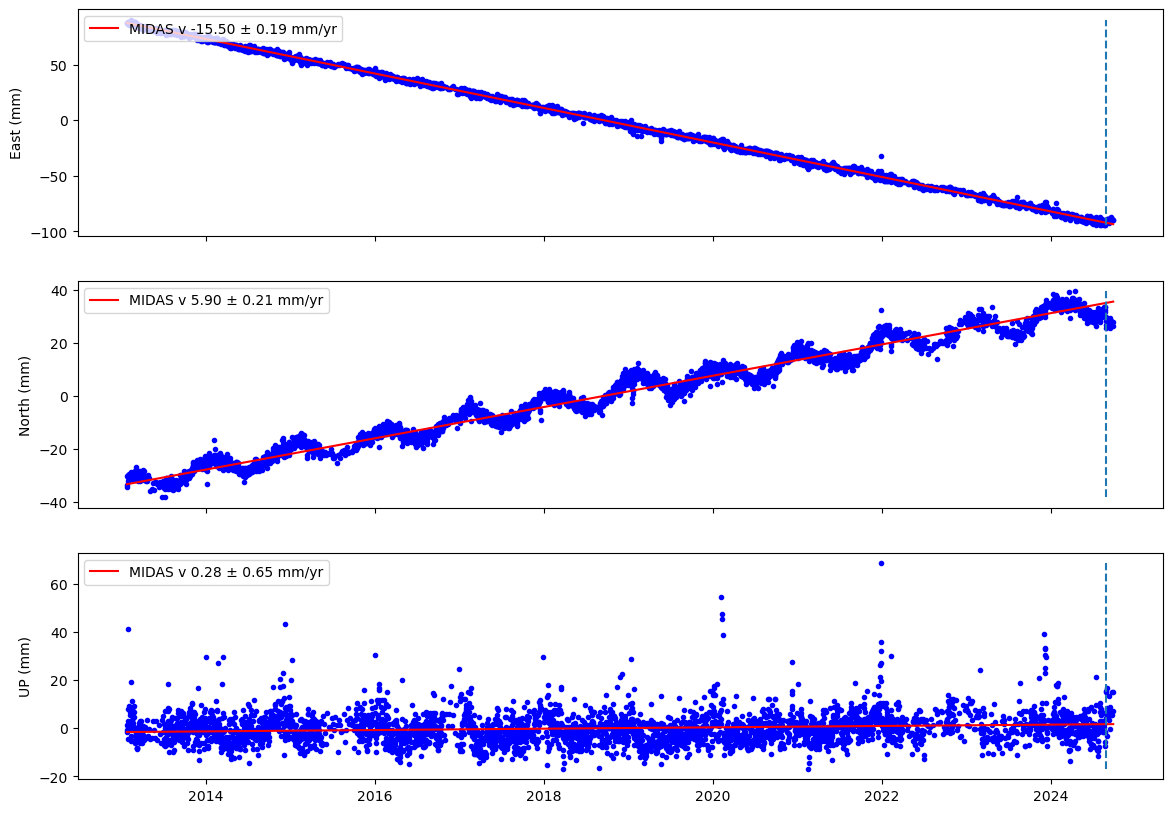

In [70]:
gnss.get_ts_fit('AA01', display=True)

In [71]:
# 3 Remove GNSS sites with 1 days gaps  with more than 35% of the record 
min_gap_percentage = 35
n_removed_sites = np.sum(gnss.gnss_df.gap_percentage > min_gap_percentage)
print(f'Number of sites with gap percentage >{min_gap_percentage}% : {n_removed_sites}')

gnss.gnss_df = gnss.gnss_df[gnss.gnss_df.gap_percentage < min_gap_percentage]

Number of sites with gap percentage >35% : 252


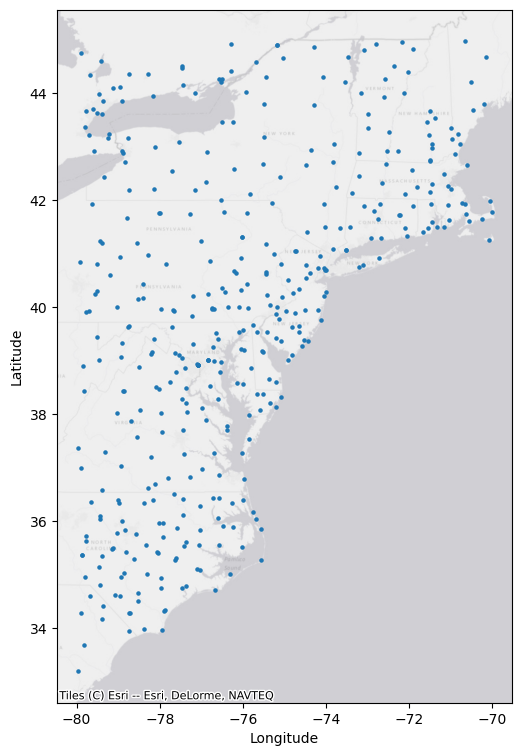

In [72]:
# Plot selected UNR GNSS sites
df_gnss = gpd.GeoDataFrame(gnss.gnss_df,
                           geometry = gpd.points_from_xy(gnss.gnss_df.lon,
                                                         gnss.gnss_df.lat),
                           crs=CRS.from_epsg(4326))

fig, ax = plt.subplots(1, figsize=(12,9))
df_gnss.plot(ax=ax, markersize=5)
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')

cx.add_basemap(ax, zoom=7,
               source=cx.providers.Esri.WorldGrayCanvas,
               crs='EPSG:4326')
               

## Manual screening

 - remove steps on the same or nearby date as that leads to singular design matrix with parametric inversion, e.g. remove M6.4 earthqake on 17Sep04 as there is another M7.1 on 17Sep06
 - avoid steps with no data in between
 - add steps where needed

Parametric fit: AA01
Parametric fit: AAM1
Parametric fit: AMTS
Parametric fit: AURO
Parametric fit: BA01
Parametric fit: BACO
Parametric fit: BASA
Parametric fit: BAST
Parametric fit: BCC1
Parametric fit: BCC2
Parametric fit: BEC4
Parametric fit: BFNY
Parametric fit: BGI1
Parametric fit: BORO
Parametric fit: BRE3
Parametric fit: BRO3
Parametric fit: BURL
Parametric fit: BURY


KeyboardInterrupt: 

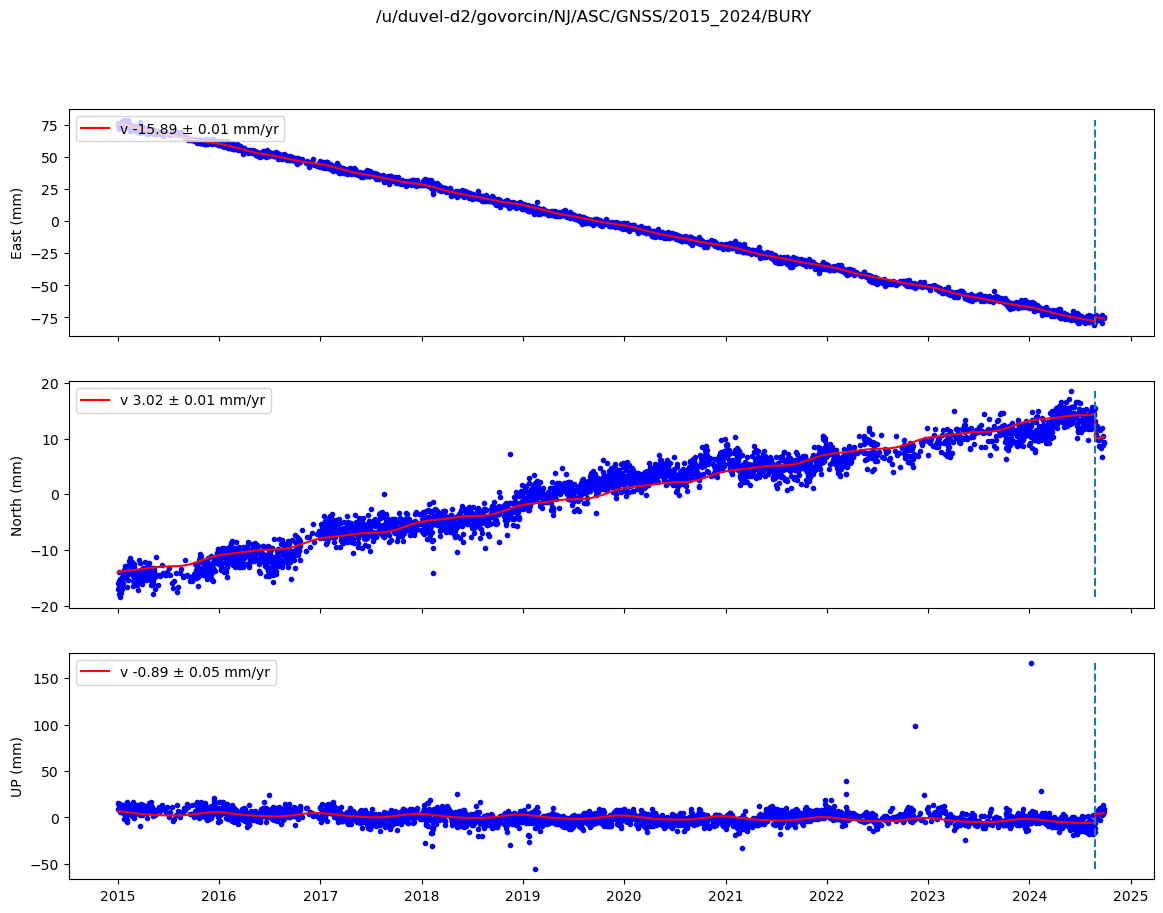

In [73]:
# Get all plots for inspection
wdir = Path('/u/duvel-d2/govorcin/NJ/ASC/GNSS/2015_2024').absolute()
plot_dir = f'gnss_plots_{start}_{end}'
(wdir / plot_dir).mkdir(exist_ok=True)

# Generate plots for inspection - use simple parameteric fitting
for site in gnss.gnss_df.site:
    gnss.get_ts_fit(site, do_hector=False, start=start, end=end,
                    poly_deg=1, periods=[1.,0.5], do_filtering=True,
                    display=True, save_fig=True)
    
# move to plot_dir
for site in list(wdir.glob('*.png')):
    site.rename(wdir / plot_dir / site.name)

In [ ]:
# Print added steps
gnss.steps[gnss.steps.description == 'added']

,site,date,code,description,threshold_distance,site_distance_from_eq,mag


## Example of adding steps

(array([[nan, nan, nan]]), array([[nan, nan, nan]]))

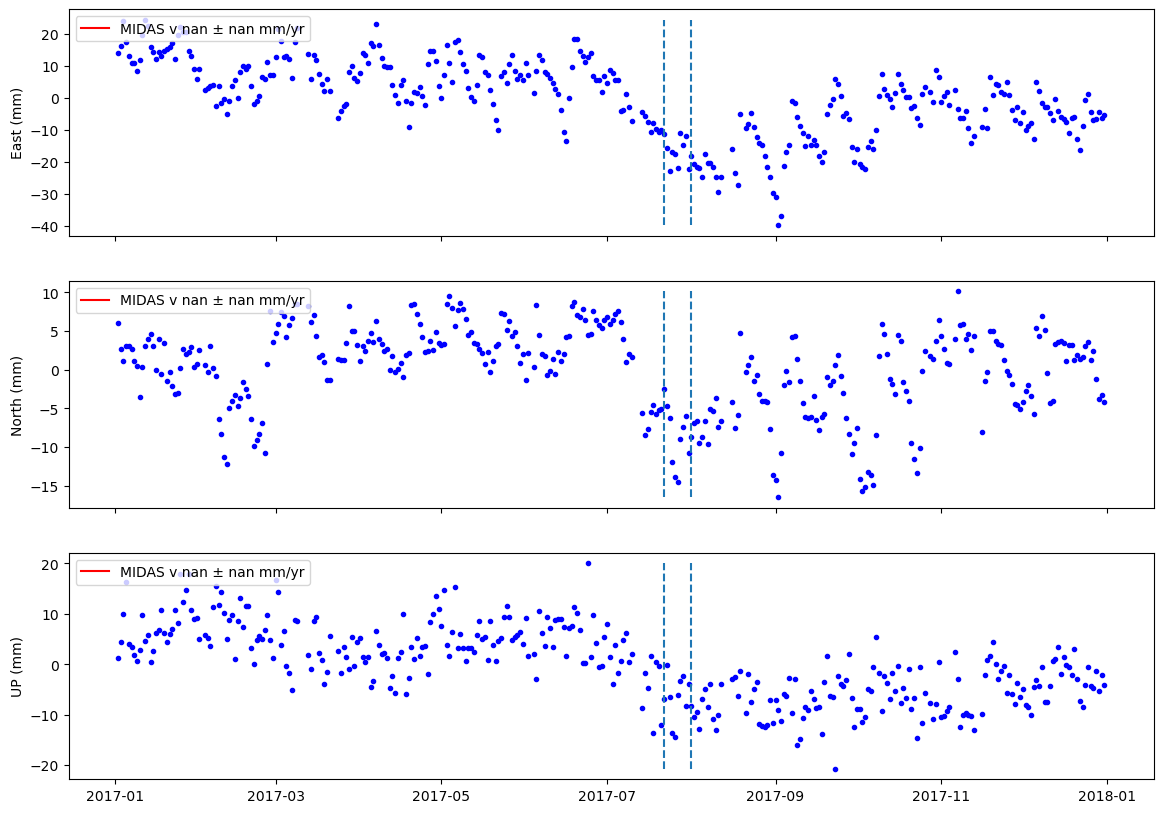

In [ ]:
gnss.get_ts_fit(site, display=True, start='20170101', end='20180101', periods=[1.,0.5])

In [ ]:
site = 'AMTS'
gnss.get_ts_fit(site, do_hector=False, start=start, end=end,
                poly_deg=1, periods=[1.,0.5], do_filtering=False,
                display=True, save_fig=False)

Parametric fit: AMTS


(array([-15.087198 ,   5.4960113,  -2.4711988], dtype=float32),
 array([0.04914029, 0.03456698, 0.03456147], dtype=float32))

<Axes: >

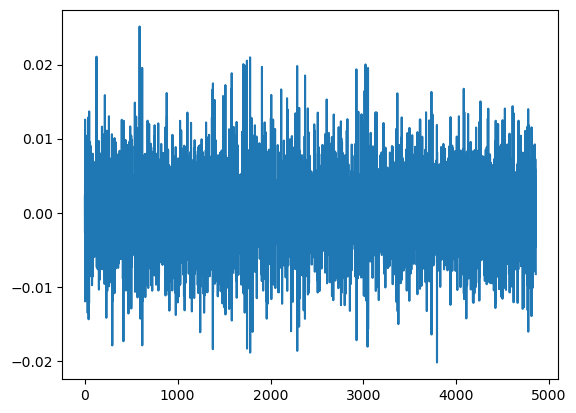

In [ ]:
gnss.read_ts_file(site).v.diff().plot()

<Axes: xlabel='decimal_yr'>

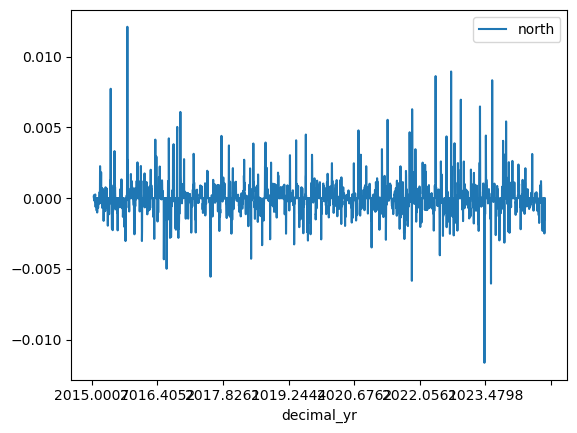

In [ ]:
pd.merge(ds[ds.decimal_yr > st_date].decimal_yr, 
         ds[ds.decimal_yr > st_date].north.rolling(mov_win).median().diff(),
         left_index=True, right_index=True).plot(x='decimal_yr')

<Axes: xlabel='decimal_yr'>

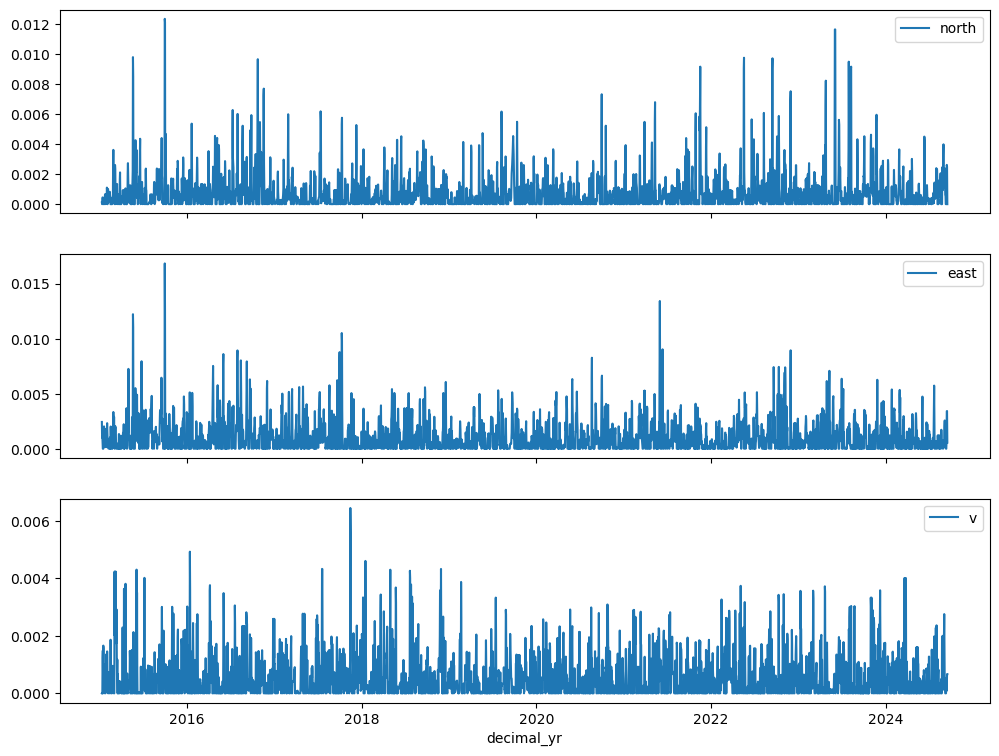

In [ ]:
ds = gnss.read_ts_file(site)
st_date = 2015
mov_win = 15
period=2
kwargs = dict(x='decimal_yr', kind='line')
fig, ax = plt.subplots(3,1, sharex=True, figsize=(12,9))
pd.merge(ds[ds.decimal_yr > st_date].decimal_yr.rolling(mov_win).mean(), 
         ds[ds.decimal_yr > st_date].north.rolling(mov_win).median().diff(periods=period).abs(),
         left_index=True, right_index=True).plot(ax=ax[0],y='north', **kwargs)

pd.merge(ds[ds.decimal_yr > st_date].decimal_yr.rolling(mov_win).mean(), 
         ds[ds.decimal_yr > st_date].east.rolling(mov_win).median().diff(periods=period).abs(),
         left_index=True, right_index=True).plot(ax=ax[1], y='east', **kwargs)

pd.merge(ds[ds.decimal_yr > st_date].decimal_yr.rolling(mov_win).mean(), 
         ds[ds.decimal_yr > st_date].v.rolling(mov_win).median().diff(periods=period).abs(),
         left_index=True, right_index=True).plot(ax=ax[2], y='v', **kwargs)

In [ ]:
data = pd.merge(ds[ds.decimal_yr > st_date].decimal_yr.rolling(30).mean(), 
                pd.merge(ds[ds.decimal_yr > st_date].v.rolling(30).median(),
                         ds[ds.decimal_yr > st_date].v.rolling(30).std(),
                         left_index=True, right_index=True),
                left_index=True, right_index=True)
data = data.dropna()

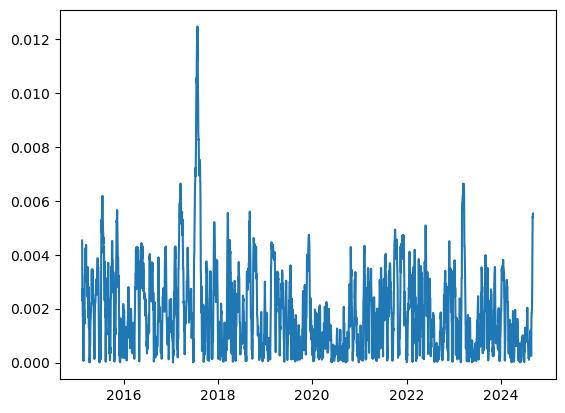

In [ ]:
plt.plot(data.decimal_yr, data.v_x.diff(periods=30).abs())

In [ ]:
rolling_mean = ds[ds.decimal_yr > st_date]["v"].rolling(window=30).mean()
rolling_std = ds[ds.decimal_yr > st_date]["v"].rolling(window=30).std()

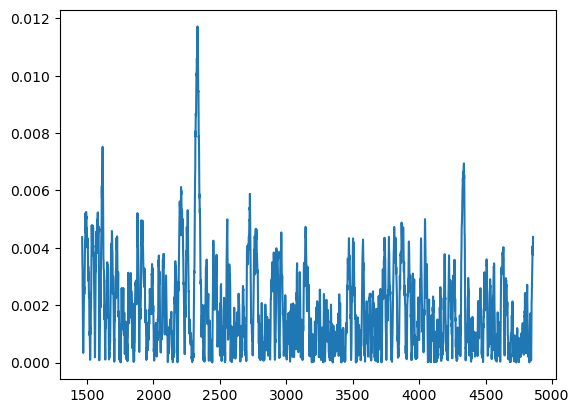

In [ ]:
plt.plot(rolling_mean.diff(periods=30).abs())

In [ ]:
#plt.plot(rolling_mean)
jumps = (ds[ds.decimal_yr > st_date]["v"] - rolling_mean).abs() > 2 * rolling_std

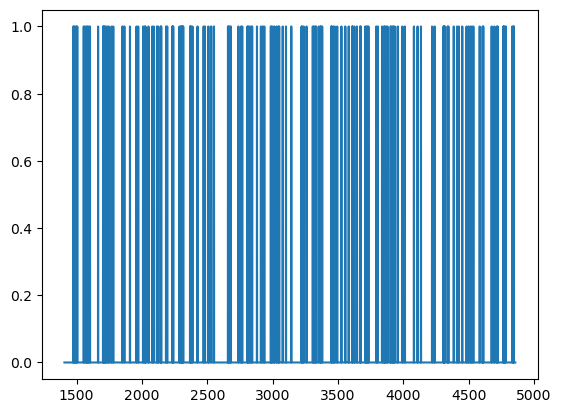

In [ ]:
plt.plot(jumps)

<Axes: xlabel='decimal_yr'>

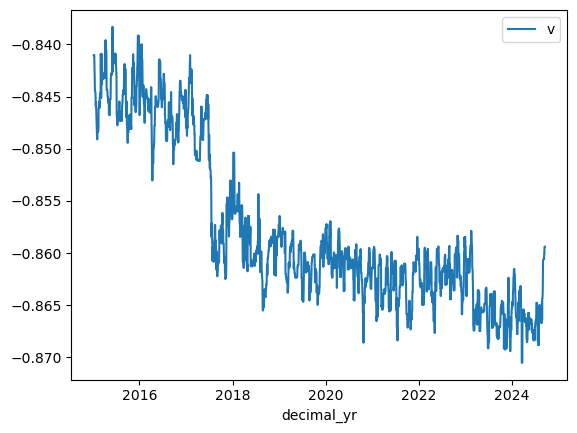

In [ ]:
data.plot(x='decimal_yr',y='v')

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)


from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(data_scaled)

# Calculate reconstruction error
reconstruction = pca.inverse_transform(principal_components)
reconstruction_error = ((data_scaled - reconstruction) ** 2).mean(axis=1)

# Detect jumps
threshold = np.percentile(reconstruction_error, 99)  # 95th percentile
jumps = reconstruction_error > threshold

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(data.decimal_yr, data.v, label="Time Series")
plt.scatter(data.decimal_yr[jumps], data.v[jumps], color="red", label="Detected Jumps")
plt.axhline(data.v.mean(), color="gray", linestyle="--", label="Mean Value")
plt.legend()
plt.show()

NameError: name 'data' is not defined

<Axes: >

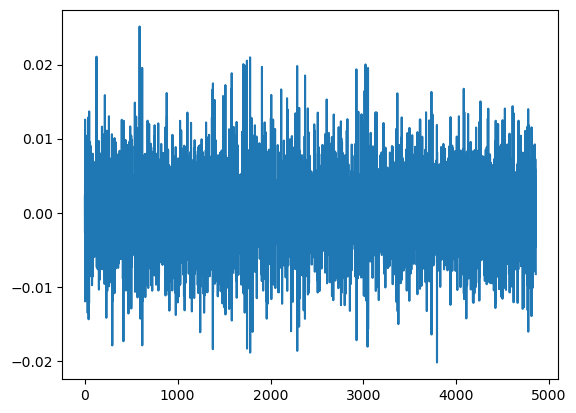

In [ ]:
gnss.read_ts_file(site).v.diff().plot()

In [ ]:
dd= pd.merge(ds[ds.decimal_yr > st_date].decimal_yr.rolling(mov_win).mean(), 
         ds[ds.decimal_yr > st_date].v.rolling(mov_win).median().diff(),
         left_index=True, right_index=True)

ix=np.where(np.abs(dd.v)>0.004)


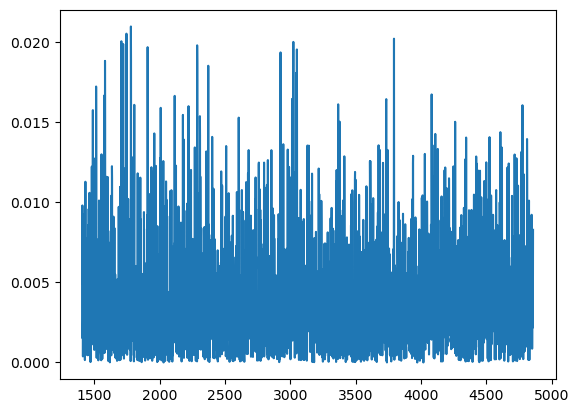

In [ ]:
plt.plot(np.abs(dd.v))

In [ ]:
dd[np.abs(dd.v) > np.nanpercentile(np.abs(dd.v), 99)]

,decimal_yr,v
1489,2015.2307,0.015757
1514,2015.3018,0.017232
1576,2015.4716,0.016671
1582,2015.4880,0.018834
1707,2015.8467,0.020058
1721,2015.8850,0.019886
1746,2015.9535,0.020532
1747,2015.9562,-0.018350
1780,2016.0465,0.020981
1781,2016.0493,-0.018885


In [ ]:
print(list(dd.decimal_yr.iloc[ix].values))

[2015.0089, 2015.0116, 2015.0144, 2015.0226, 2015.0253, 2015.0308, 2015.0335, 2015.0418, 2015.0445, 2015.0472, 2015.05, 2015.0664, 2015.0691, 2015.0719, 2015.0746, 2015.0773, 2015.0801, 2015.0828, 2015.0856, 2015.1239, 2015.1266, 2015.1321, 2015.1376, 2015.1403, 2015.1431, 2015.1513, 2015.1567, 2015.1677, 2015.1759, 2015.1814, 2015.1841, 2015.1869, 2015.1896, 2015.1923, 2015.1951, 2015.2005, 2015.2033, 2015.206, 2015.2088, 2015.2252, 2015.2307, 2015.2334, 2015.2361, 2015.2526, 2015.2553, 2015.258, 2015.2635, 2015.2663, 2015.269, 2015.2717, 2015.2799, 2015.2854, 2015.2909, 2015.2936, 2015.2964, 2015.3018, 2015.3046, 2015.3073, 2015.3101, 2015.3183, 2015.321, 2015.3265, 2015.3292, 2015.3457, 2015.3621, 2015.3676, 2015.3703, 2015.373, 2015.3812, 2015.3895, 2015.3949, 2015.4031, 2015.4059, 2015.4114, 2015.4141, 2015.4223, 2015.4251, 2015.4278, 2015.436, 2015.4415, 2015.4442, 2015.4524, 2015.4579, 2015.4634, 2015.4716, 2015.4743, 2015.488, 2015.4908, 2015.4962, 2015.499, 2015.5099, 2015.518

In [ ]:
gnss.steps[gnss.steps.description =='added']

,site,date,code,description,threshold_distance,site_distance_from_eq,mag
1135,AMTS,17NOV22,0,added,0,0,0


In [ ]:
gnss.steps = gnss.steps.drop(index=1135)

In [ ]:
ix = np.where(np.abs(ds[ds.decimal_yr > 2015].v.rolling(15).median().diff().values) > 0.004)
print(list(ds[ds.decimal_yr > 2015].yyyymmdd.iloc[ix].values))

['15JUN11', '15JUN12', '17NOV22', '24MAR26', '24MAR31']


In [ ]:
# Manually add the step 
step = '17JUL22'
index = gnss.steps.index.max() + 1
gnss.steps.loc[index] = [site, step, 0, 'added', 0, 0, 0]

# Calculate Temporal Variability

In [74]:
%%time
import itertools
from tqdm.contrib.concurrent import process_map


sites = gnss.gnss_df.site.values
n = len(sites)
min_span = itertools.repeat(3, n)
start_list= itertools.repeat(start, n) 

# Temporal velocity variability using MIDAS with default min window span of 3 years
res = process_map(gnss.get_dV, sites, min_span, start_list, max_workers=30)
dV = [i[:3] for i in res]

  0%|          | 0/416 [00:00<?, ?it/s]

CPU times: user 1.84 s, sys: 471 ms, total: 2.31 s
Wall time: 36.5 s


Text(0.5, 0, 'Data Span [year]')

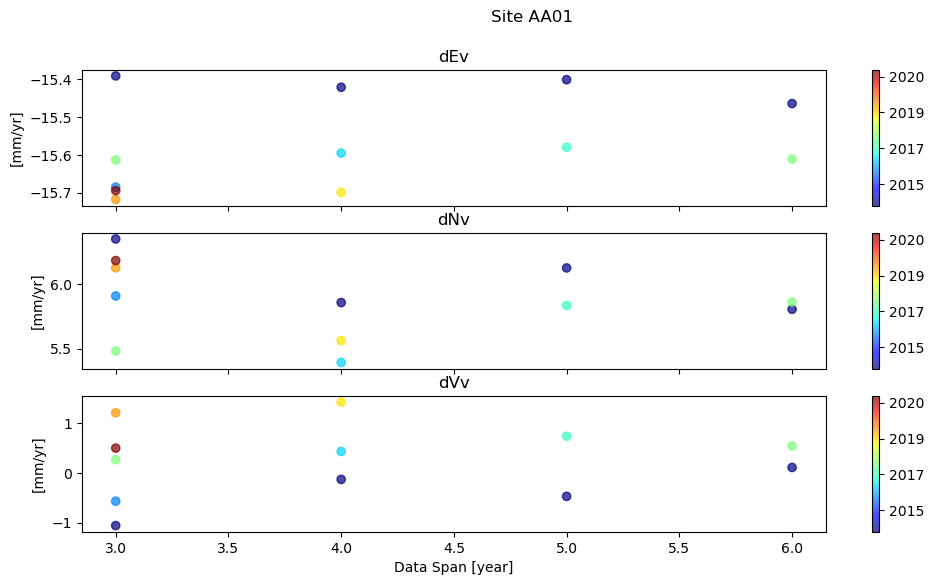

In [75]:
# Plot example of Temporal Velocity Variability

# Get the result for the first site
site_dv_res = res[0]

# Plot temporal velocity variability for each displacement component
fig, ax = plt.subplots(3,1, figsize=(12,6), sharex=True)

im = [ax[ix].scatter(np.hstack(site_dv_res[4]), np.vstack(site_dv_res[3])[:,ix], 
                     c=np.hstack(site_dv_res[5]), cmap='jet', alpha=0.7) for ix in range(0,3)]

for i, a, txt in zip(im, ax, ['dEv', 'dNv', 'dVv']):
    cb = fig.colorbar(i, ax=a)
    clables = [datetime.strftime(datetime.utcfromtimestamp(ix), "%Y") for ix in cb.get_ticks()]
    cb.ax.set_yticklabels(clables)
    a.set_title(f'{txt}')
    #ax.set_xticks(np.arange(1, max_window))
    a.set_ylabel('[mm/yr]')
fig.suptitle(f'Site {gnss.gnss_df.site.iloc[0]}')
ax[2].set_xlabel('Data Span [year]')

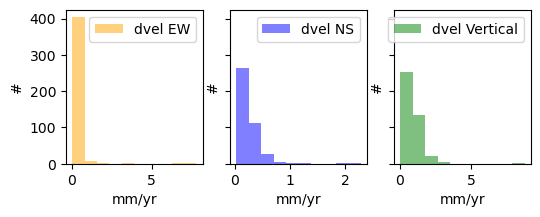

In [76]:
# Add columns 
gnss.gnss_df['dEv'] = np.NaN
gnss.gnss_df['dNv'] = np.NaN
gnss.gnss_df['dVv'] = np.NaN

gnss.gnss_df['dEv'] = np.vstack(dV)[:, 0]
gnss.gnss_df['dNv'] = np.vstack(dV)[:, 1]
gnss.gnss_df['dVv'] = np.vstack(dV)[:, 2]

# Show the histograms
fig, ax = plt.subplots(1,3, sharey=True,figsize=(6,2))
ax[0].hist(gnss.gnss_df['dEv'], color='orange', alpha=0.5, label='dvel EW')
ax[1].hist(gnss.gnss_df['dNv'], color='blue', alpha=0.5, label='dvel NS')
ax[2].hist(gnss.gnss_df['dVv'], color='green', alpha=0.5, label='dvel Vertical')
for a in ax: a.legend(), a.set_xlabel('mm/yr'), a.set_ylabel('#')

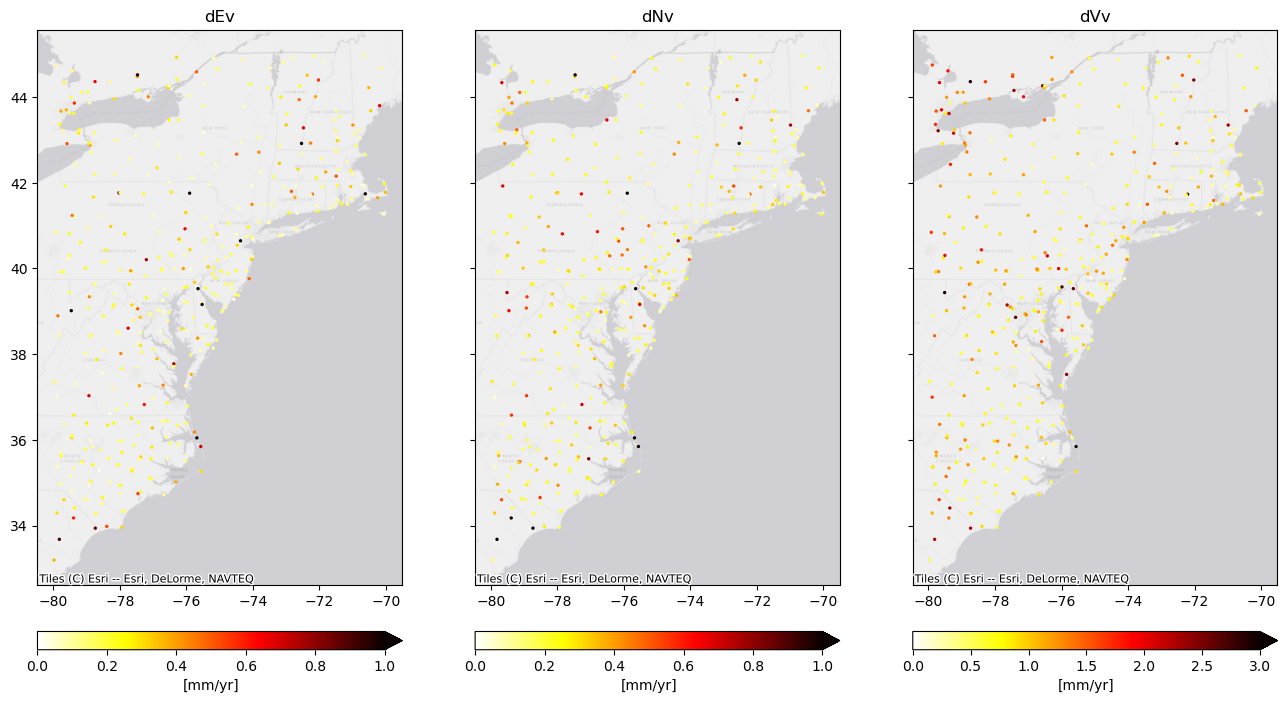

In [77]:
# Geo Dataframe
df_gnss = gpd.GeoDataFrame(gnss.gnss_df,
                           geometry = gpd.points_from_xy(gnss.gnss_df.lon,
                                                         gnss.gnss_df.lat),
                           crs=CRS.from_epsg(4326))

# Plot
kwargs =dict(markersize=2, cmap='hot_r', zorder=1)
fig, ax = plt.subplots(1, 3, figsize=(16,12), sharey=True)
im1 = df_gnss.plot(ax=ax[0], column='dEv', vmin=0, vmax=1, **kwargs)
im2 = df_gnss.plot(ax=ax[1], column='dNv', vmin=0, vmax=1, **kwargs)
im3 = df_gnss.plot(ax=ax[2], column='dVv', vmin=0, vmax=3, **kwargs)
for a, txt in zip(ax, ['dEv', 'dNv', 'dVv']): a.set_title(txt)
for a, im in zip(ax, [im1, im2, im3]): 
    fig.colorbar(im.collections[0], ax=a.axes, 
                 location='bottom', pad=0.05, 
                 extend='max', label='[mm/yr]')

# plot plates
for a in ax:
    cx.add_basemap(a, zoom=7,
                   source=cx.providers.Esri.WorldGrayCanvas, 
                   crs='EPSG:4326')

## Calculate MIDAS velocities

In [78]:
gnss._update_df_with_ts(do_midas=True, start=start, end=end)

Processing AA01:   0%|          | 0/416 [00:00<?, ?it/s]

Processing ZNY1: 100%|██████████| 416/416 [03:53<00:00,  1.78it/s]


In [79]:
# Show dataframe
gnss.gnss_df.head()

,site,lat,lon,n,e,v,sn,se,sv,n_gaps,duration,start_date,end_date,ts_path,gap_percentage,dEv,dNv,dVv
670,AA01,43.672798,-71.486298,5.903038,-15.549634,0.326261,0.234352,0.207884,0.726918,NaN,10.01232,2015-01-01,2025-01-05,nan,20.858393,0.123470,0.238150,0.433602
674,AAM1,39.996899,-76.089905,4.250335,-14.696062,-0.936613,0.273655,0.243861,0.931513,NaN,10.01232,2015-01-01,2025-01-05,nan,24.412247,0.405387,0.156600,1.975164
1286,AMTS,41.741901,-70.617493,5.364692,-15.480564,-1.901319,0.719631,1.012652,0.641456,NaN,10.01232,2015-01-01,2025-01-05,nan,5.604155,1.127881,0.233128,1.016681
1675,AURO,43.991901,-79.455109,3.516399,-15.518623,0.559355,0.253919,0.231448,0.727116,NaN,10.01232,2015-01-01,2025-01-05,nan,17.113177,0.165115,0.390260,1.211817
1868,BA01,44.335999,-79.669891,2.132445,-16.625878,0.344214,0.248267,0.263267,0.707759,NaN,10.01232,2015-01-01,2025-01-05,nan,19.792236,0.217652,0.681479,1.975279


In [80]:
# Load plates: 
# Bird, P. (2003), An updated digital model of plate boundaries, Geochem. Geophys. Geosyst., 4, 1027, doi:10.1029/2001GC000252, 3. 
# Source URl: https://github.com/fraxen/tectonicplates
plates = gpd.read_file('/u/duvel-d2/govorcin/NJ/ASC/GNSS/Venti/data/plates/PB2002_boundaries.json')

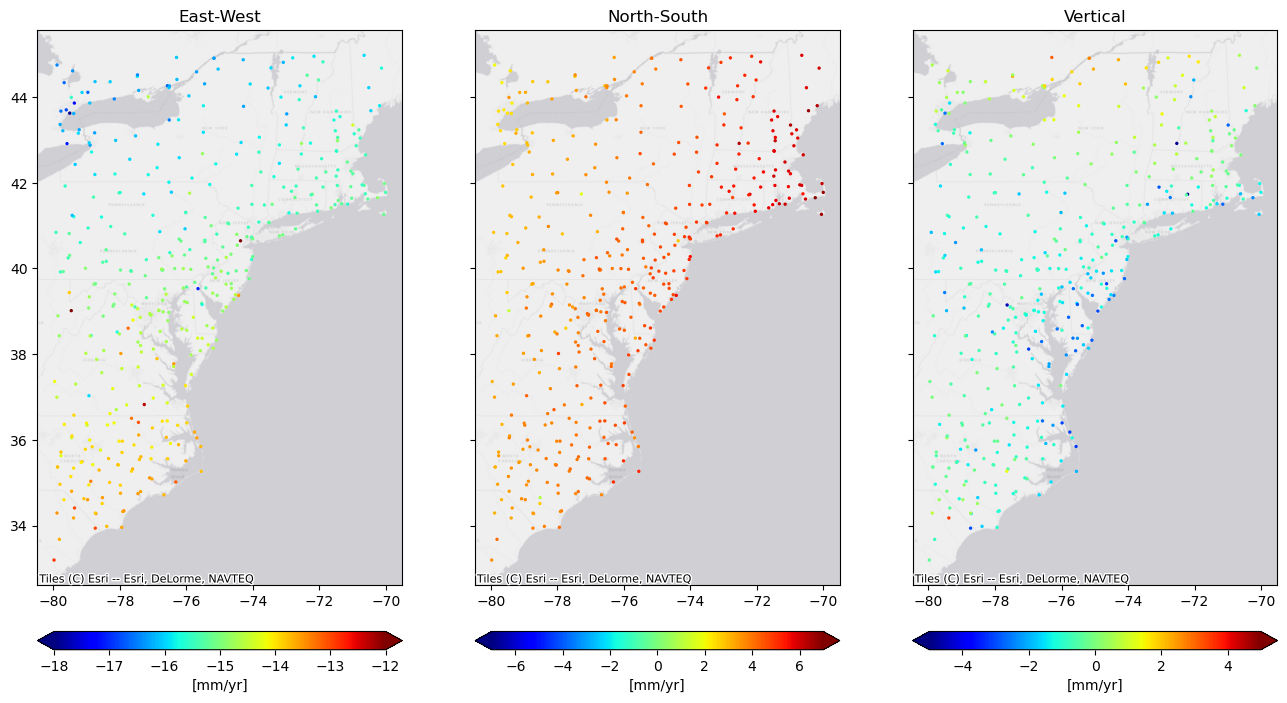

In [81]:
# Geo Dataframe
df_gnss = gpd.GeoDataFrame(gnss.gnss_df,
                           geometry = gpd.points_from_xy(gnss.gnss_df.lon,
                                                         gnss.gnss_df.lat),
                           crs=CRS.from_epsg(4326))

# Plot
kwargs =dict(markersize=2, cmap='jet', zorder=1)
fig, ax = plt.subplots(1, 3, figsize=(16,12), sharey=True)
im1 = df_gnss.plot(ax=ax[0], column='e', vmin=-18, vmax=-12, **kwargs)
im2 = df_gnss.plot(ax=ax[1], column='n', vmin=-7, vmax=7, **kwargs)
im3 = df_gnss.plot(ax=ax[2], column='v', vmin=-5, vmax=5, **kwargs)
for a, txt in zip(ax, ['East-West', 'North-South', 'Vertical']): a.set_title(txt)
for a, im in zip(ax, [im1, im2, im3]): 
    fig.colorbar(im.collections[0], ax=a.axes, 
                 location='bottom', pad=0.05, 
                 extend='both', label='[mm/yr]')

# plot plates
for a in ax:
    #plates.plot(ax=a, lw=1, color='black',zorder=2)
    cx.add_basemap(a, zoom=7,
    source=cx.providers.Esri.WorldGrayCanvas, 
    crs='EPSG:4326')

In [ ]:
# Save it locally for next steps
gnss.save(gnss_midas_pickle)

## GPS Imaging - additional quality metrics

In [82]:
df_gnss.keys()

Index(['site', 'lat', 'lon', 'n', 'e', 'v', 'sn', 'se', 'sv', 'n_gaps',
       'duration', 'start_date', 'end_date', 'ts_path', 'gap_percentage',
       'dEv', 'dNv', 'dVv', 'geometry'],
      dtype='object')

In [83]:
from venti.gnss.quality import compute_delaunay_network, calculate_ssf, calculate_spatial_variability, calculate_network_ssf, get_network_distance_stat

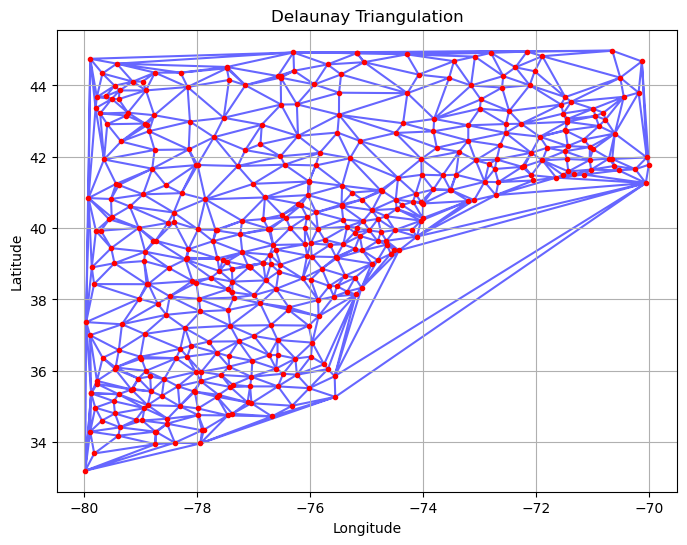

In [ ]:
# Test functions
tri = compute_delaunay_network(gnss.gnss_df.lon,
                               gnss.gnss_df.lat,
                               visualize=True)

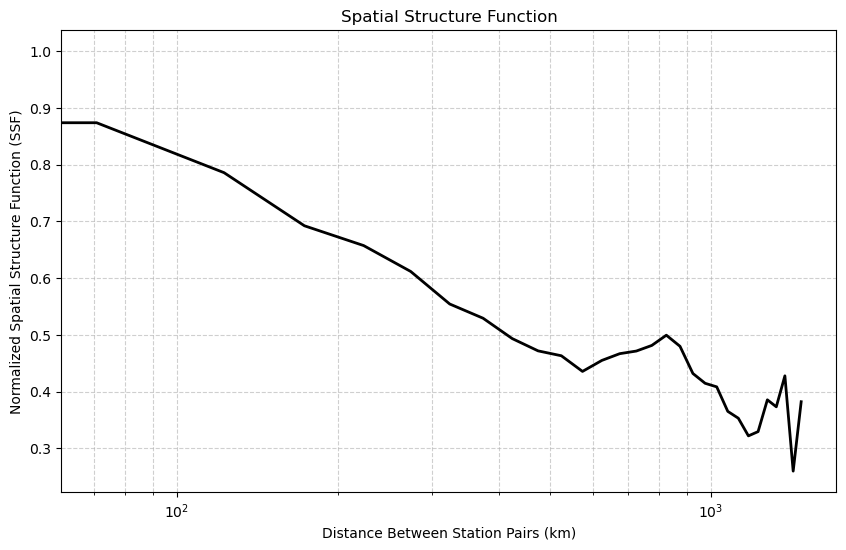

SSF: 0.46672748667909525


In [84]:
# Get ssf for all data
print('SSF:', np.nanmedian(calculate_ssf(gnss.gnss_df.lon,
                            gnss.gnss_df.lat,
                            gnss.gnss_df.v,
                            gnss.gnss_df.sv,
                            dvmax=30, bin_spacing=50,
                            visualize=True, distance_km=True)[:,1]))

Text(0.5, 1.0, 'Spatial var. MAD')

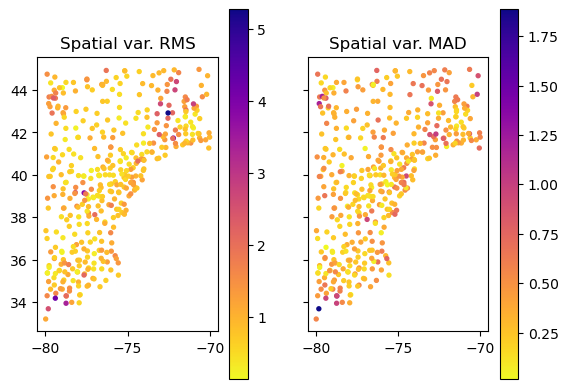

In [92]:
df_gnss = gpd.GeoDataFrame(gnss.gnss_df,
                           geometry = gpd.points_from_xy(gnss.gnss_df.lon,
                                                         gnss.gnss_df.lat),
                           crs=CRS.from_epsg(4326))

# GET SPATIAL VAR. FOR NEIGHBORING SITES
spatial_var = calculate_spatial_variability(df_gnss.lon, df_gnss.lat,
                                            df_gnss.v.values)

df_gnss['spatial_var_v_rms'] = spatial_var[:, 0]
df_gnss['spatial_var_v_mad'] = spatial_var[:, 1]

# EW
spatial_var = calculate_spatial_variability(df_gnss.lon, df_gnss.lat,
                                            df_gnss.e.values)

df_gnss['spatial_var_e_rms'] = spatial_var[:, 0]
df_gnss['spatial_var_e_mad'] = spatial_var[:, 1]

#NS
spatial_var = calculate_spatial_variability(df_gnss.lon, df_gnss.lat,
                                            df_gnss.n.values)

df_gnss['spatial_var_n_rms'] = spatial_var[:, 0]
df_gnss['spatial_var_n_mad'] = spatial_var[:, 1]

fig, ax = plt.subplots(1,2, sharey=True)
df_gnss.plot(ax=ax[0], column='spatial_var_v_rms', cmap='plasma_r', legend=True, markersize=8)
df_gnss.plot(ax=ax[1], column='spatial_var_v_mad', cmap='plasma_r', legend=True, markersize=8)

ax[0].set_title('Spatial var. RMS')
ax[1].set_title('Spatial var. MAD')

Update_bin_spacing 1.8
Update_bin_spacing 1.8
Update_bin_spacing 1.8


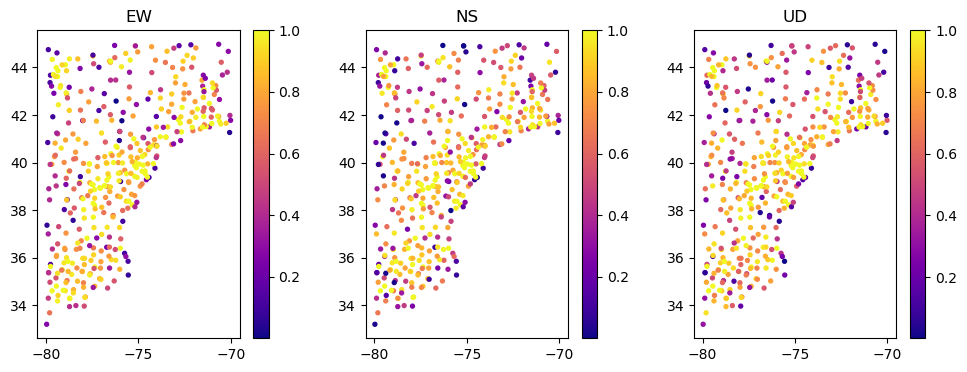

In [93]:
ssf_v = calculate_network_ssf(df_gnss.site.values, df_gnss.lon.values, df_gnss.lat.values,
                      df_gnss.v.values, df_gnss.sv.values)
ssf_v = ssf_v.rename(columns={'ssf':'ssf_v'})
ssf_v = ssf_v.drop(columns='ssf_npoints')
df = pd.merge(df_gnss, ssf_v, left_on='site', right_on='site')

ssf_e = calculate_network_ssf(df_gnss.site.values, df_gnss.lon.values, df_gnss.lat.values,
                      df_gnss.e.values, df_gnss.se.values)
ssf_e = ssf_e.rename(columns={'ssf':'ssf_e'})
ssf_e = ssf_e.drop(columns='ssf_npoints')
df = pd.merge(df, ssf_e, left_on='site', right_on='site')

ssf_n = calculate_network_ssf(df_gnss.site.values, df_gnss.lon.values, df_gnss.lat.values,
                      df_gnss.n.values, df_gnss.sn.values)
ssf_n = ssf_n.rename(columns={'ssf':'ssf_n'})
df = pd.merge(df, ssf_n, left_on='site', right_on='site')

fig, ax = plt.subplots(1,3, figsize=(12,4))
df.plot('ssf_e', ax=ax[0], cmap='plasma', legend=True, markersize=8)
df.plot('ssf_n', ax=ax[1], cmap='plasma', legend=True, markersize=8)
df.plot('ssf_v', ax=ax[2], cmap='plasma', legend=True, markersize=8)

for a, txt in zip(ax, ['EW', 'NS', 'UD']): a.set_title(txt)

In [94]:
df_dist = get_network_distance_stat(df_gnss.site.values,
                          df_gnss.lon.values,
                          df_gnss.lat.values)

In [95]:
df_dist

,site,dmin,dmax,dmean,dmedian,npoints
0,MHC1,61.304761,160.100991,103.939146,94.854667,8
1,PACS,5.370503,78.092490,52.561200,60.210740,5
2,PL12,55.379366,81.045276,69.844556,71.117339,8
3,BASA,33.689487,433.898042,177.769404,112.728460,10
4,BURL,17.613913,280.012006,113.972878,95.782653,6
...,...,...,...,...,...,...
406,MEGO,24.810752,115.068387,66.664003,59.907874,7
407,DCDC,3.938624,42.182755,26.074343,25.709789,6
408,BCC2,5.578428,46.524301,26.294128,26.779656,3
409,P776,16.810821,102.296496,48.214887,38.362773,6


In [96]:
df= pd.merge(df, df_dist, left_on='site', right_on='site')

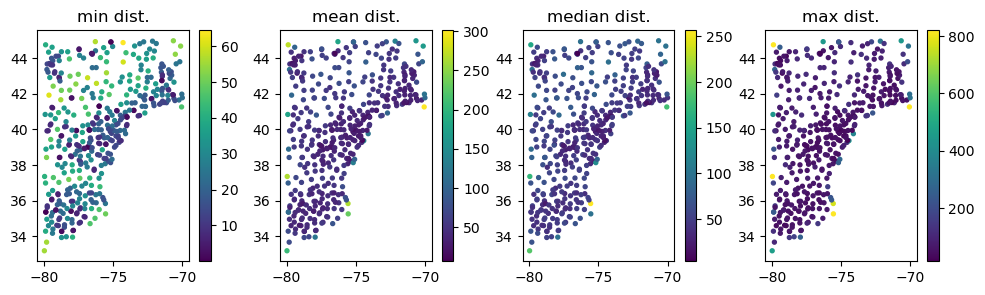

In [97]:
fig, ax = plt.subplots(1,4, figsize=(12,3))
df.plot('dmin', ax=ax[0], legend=True, markersize=8)
df.plot('dmean', ax=ax[1], legend=True, markersize=8)
df.plot('dmedian', ax=ax[2], legend=True, markersize=8)
df.plot('dmax', ax=ax[3], legend=True, markersize=8)

for a, txt in zip(ax, ['min dist.', 'mean dist.', 'median dist.', 'max dist.']):
    a.set_title(txt)

In [98]:
df.keys()

Index(['site', 'lat', 'lon', 'n', 'e', 'v', 'sn', 'se', 'sv', 'n_gaps',
       'duration', 'start_date', 'end_date', 'ts_path', 'gap_percentage',
       'dEv', 'dNv', 'dVv', 'geometry', 'spatial_var_v_rms',
       'spatial_var_v_mad', 'spatial_var_e_rms', 'spatial_var_e_mad',
       'spatial_var_n_rms', 'spatial_var_n_mad', 'ssf_v', 'ssf_e', 'ssf_n',
       'ssf_npoints', 'dmin', 'dmax', 'dmean', 'dmedian', 'npoints'],
      dtype='object')

In [99]:
gnss.gnss_df = df
gnss.save(gnss_midas_pickle)

# Calculate velocities with Hector

Bos et al. (2013), "Fast error analysis of  continuous GNSS observations with missing data", Journal of Geodesy, DOI 10.1007/s00190-012-0605-0


In [ ]:
# Problematic sites
gnss_reprocess = [ 'SGPS',
                  'SGU1', 'SILK', 'SPK1', 'THMG', 'TRAK', 'TWMS', 'UNR1']

In [ ]:
site = 'UNR1'
gnss.steps[gnss.steps.site == site]

,site,date,code,description,threshold_distance,site_distance_from_eq,mag
844,UNR1,05APR20,1,Receiver_Make_and_Model_Changed,NaN,NaN,NaN
1432,UNR1,10APR04,2,ci14607652,645.654,440.480,7.2
3012,UNR1,19JUL04,2,ci38443183,257.040,212.196,6.4
4257,UNR1,19JUL06,2,ci38457511,575.440,218.521,7.1


In [ ]:
gnss.steps.loc[200] = ['SGU1', '12SEP17',1, 'Antenna_and_Radome_Codes_Changed', np.nan, np.nan, np.nan]

In [ ]:
gnss.steps = gnss.steps.drop(index=3012)

n_outliers=1, m=3557, k=794, n=7
n_outliers=1, m=3557, k=794, n=7
n_outliers=1, m=3557, k=794, n=7
treshold=7.410547,  median=0.203104treshold=15.409769,  median=-0.275437treshold=41.853307,  median=1.669913

i=358, n_outliers=1
i=3095, n_outliers=1i=22, n_outliers=1


i=359, n_outliers=2n_outliers=1, m=3557, k=794, n=7i=1522, n_outliers=2

treshold=15.378211,  median=-0.274361

n_outliers=2, m=3557, k=794, n=7
i=360, n_outliers=3
i=361, n_outliers=4
i=363, n_outliers=5
i=497, n_outliers=6treshold=41.876265,  median=1.673876

i=500, n_outliers=7
i=502, n_outliers=8
i=959, n_outliers=9
i=1354, n_outliers=10
i=1679, n_outliers=11
i=3301, n_outliers=12
i=3328, n_outliers=13
i=3391, n_outliers=14
n_outliers=14, m=3557, k=794, n=7
treshold=7.307222,  median=0.178490
i=499, n_outliers=1
i=1523, n_outliers=2
n_outliers=2, m=3557, k=794, n=7
treshold=7.293223,  median=0.175847


(array([-14.69212464,   5.590392  ,  -1.40193312]),
 array([0.10355751, 0.39085467, 1.08050387]))

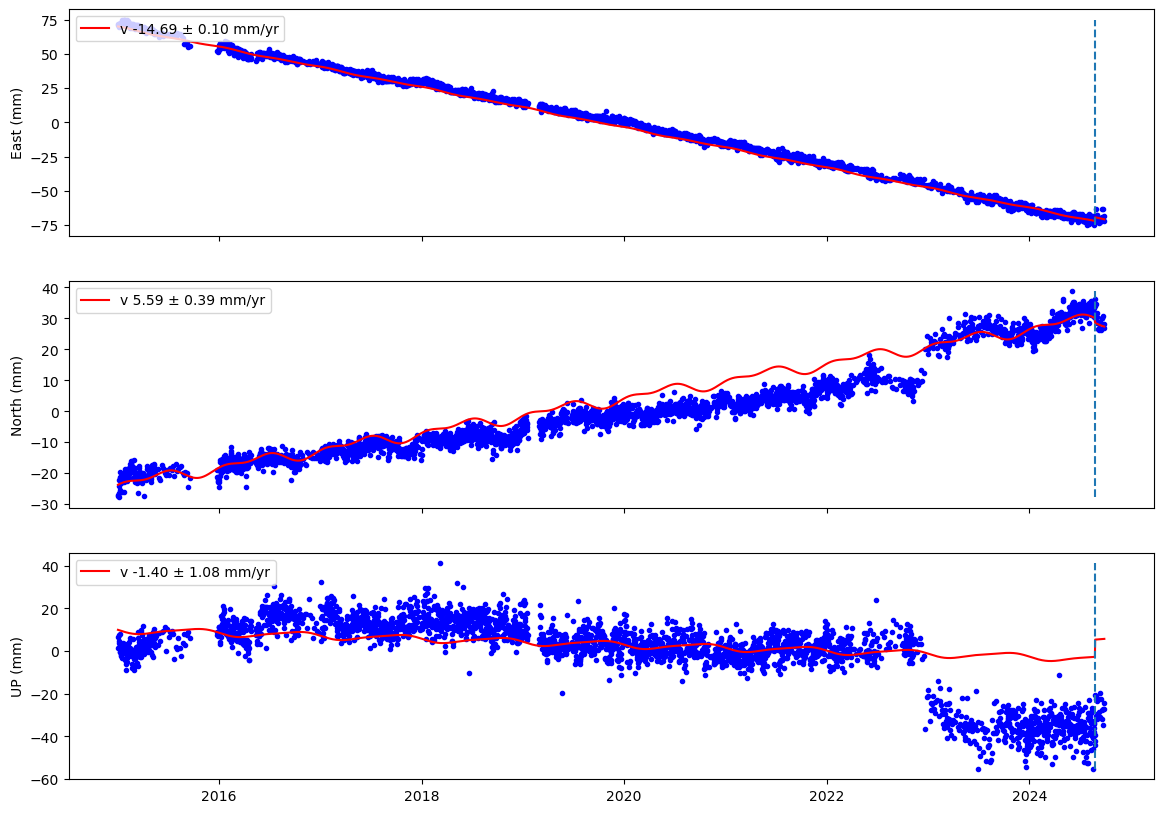

In [ ]:
%matplotlib inline
gnss.get_ts_fit('AAM1', do_hector=True, start=start, end=end, 
                poly_deg=1, periods=[1.,0.5], do_filtering=True,
                display=True, save_fig=False)

In [ ]:
gnss.gnss_df[gnss.gnss_df.site == site]

,site,lat,lon,n,e,v,sn,se,sv,n_gaps,duration,start_date,end_date,ts_path,gap_percentage,dEv,dNv,dVv
19568,UNR1,36.247299,-115.242706,-8.908982,-14.356957,-6.051663,0.108989,0.18537,0.33344,NaN,11.000684,2012-01-01,2023-01-01,nan,15.725305,0.473015,0.255954,1.901987


In [ ]:
# Save it locally for next steps
#gnss.save(gnss_hector_pickle)

In [ ]:
# Skip running this cell in the notebook as it takes some time
# Rather run script run_hector.py in the background and inspect results later
#gnss._update_df_with_ts(do_hector=True, start=start, end=end, poly_deg=1, periods=[1.,0.5], do_filtering=True)


In [ ]:
# Load Hector result
gnss = gnss.load(gnss_hector_pickle)

LOAD pickle: /u/trappist-r0/govorcin/01_OPERA/VLM/Houston/vlm/gnss/GNSS/unr_gnss_hector_2014_2024.pickle.pkl


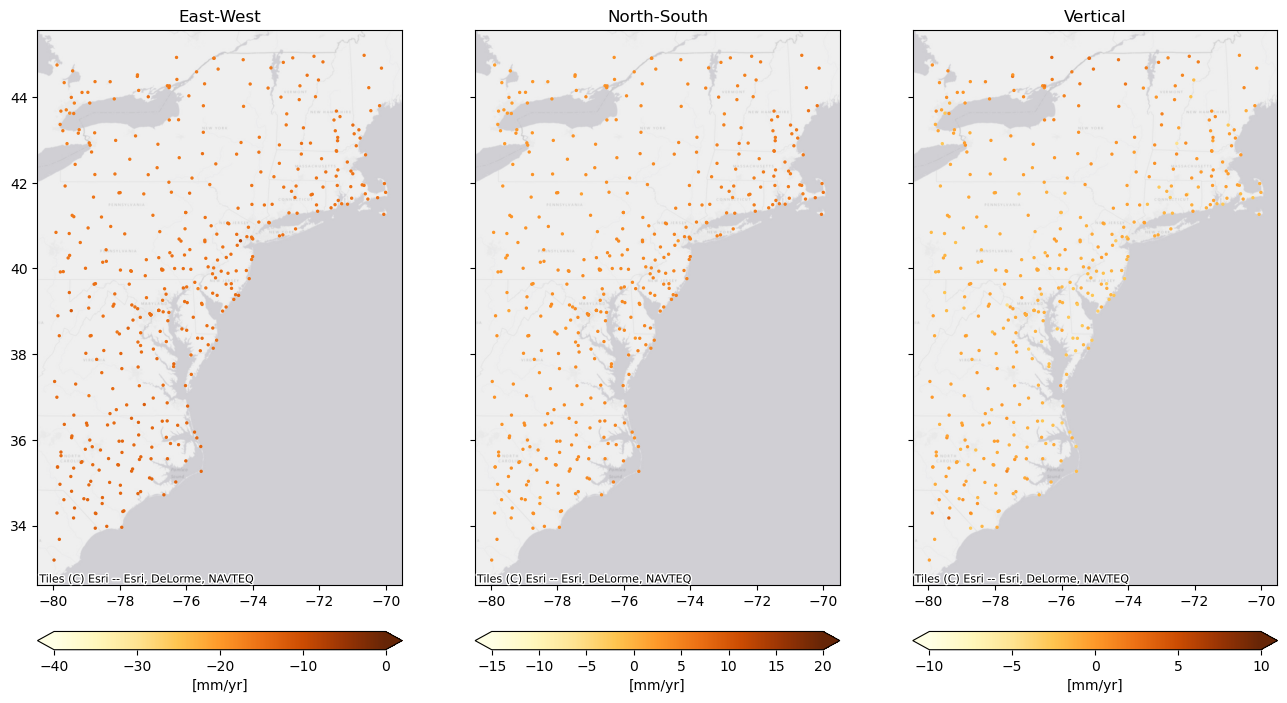

In [ ]:
# Geo Dataframe
df_gnss = gpd.GeoDataFrame(gnss.gnss_df,
                           geometry = gpd.points_from_xy(gnss.gnss_df.lon,
                                                         gnss.gnss_df.lat),
                           crs=CRS.from_epsg(4326))

# Plot
fig, ax = plt.subplots(1, 3, figsize=(16,12), sharey=True)
im1 = df_gnss.plot(ax=ax[0], column='e', vmin=-40, vmax=0, **kwargs)
im2 = df_gnss.plot(ax=ax[1], column='n', vmin=-15, vmax=20, **kwargs)
im3 = df_gnss.plot(ax=ax[2], column='v', vmin=-10, vmax=10, **kwargs)
for a, txt in zip(ax, ['East-West', 'North-South', 'Vertical']): a.set_title(txt)
for a, im in zip(ax, [im1, im2, im3]): 
    fig.colorbar(im.collections[0], ax=a.axes, 
                 location='bottom', pad=0.05, 
                 extend='both', label='[mm/yr]')

# plot plates
for a in ax:
    #plates.plot(ax=a, lw=1, color='black',zorder=2)
    cx.add_basemap(a, zoom=7,
                   source=cx.providers.Esri.WorldGrayCanvas, 
                   crs='EPSG:4326')

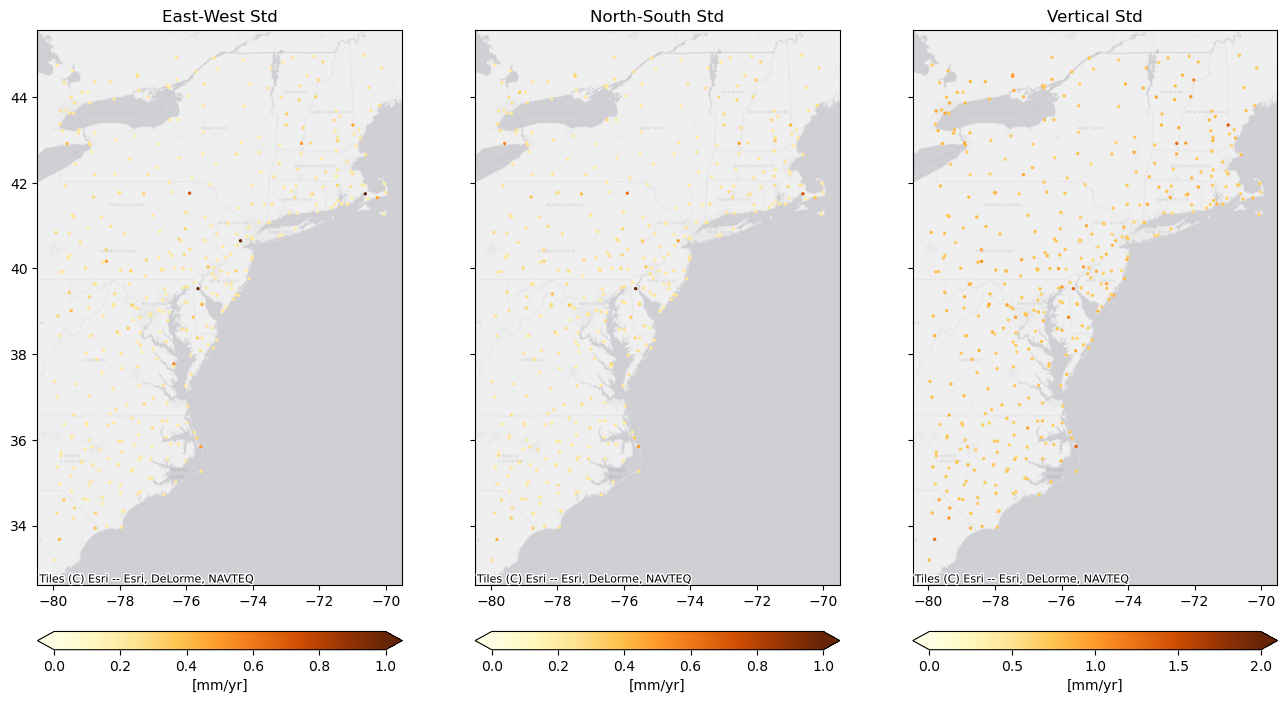

In [ ]:
# Plot
fig, ax = plt.subplots(1, 3, figsize=(16,12), sharey=True)
kwargs['cmap'] = 'YlOrBr'
im1 = df_gnss.plot(ax=ax[0], column='se', vmin=0, vmax=1, **kwargs)
im2 = df_gnss.plot(ax=ax[1], column='sn', vmin=0, vmax=1, **kwargs)
im3 = df_gnss.plot(ax=ax[2], column='sv', vmin=0, vmax=2, **kwargs)
for a, txt in zip(ax, ['East-West Std', 'North-South Std', 'Vertical Std']): a.set_title(txt)
for a, im in zip(ax, [im1, im2, im3]): 
    fig.colorbar(im.collections[0], ax=a.axes, 
                 location='bottom', pad=0.05, 
                 extend='both', label='[mm/yr]')

# plot plates
for a in ax:
    #plates.plot(ax=a, lw=1, color='black',zorder=2)
    cx.add_basemap(a, zoom=7,
                   source=cx.providers.Esri.WorldGrayCanvas, 
                   crs='EPSG:4326')

# Comparison between MIDAS and HECTOR solutions

In [ ]:
# Load Hector result
gnss_midas = gnss.load(gnss_midas_pickle)
gnss_hector = gnss.load(gnss_hector_pickle)

# Geopandas
points = gpd.points_from_xy(gnss_midas.gnss_df.lon,
                            gnss_midas.gnss_df.lat)
df_midas = gpd.GeoDataFrame(gnss_midas.gnss_df,
                           geometry = points,
                           crs='EPSG:4326')
df_hector = gpd.GeoDataFrame(gnss_hector.gnss_df,
                           geometry = points,
                           crs='EPSG:4326')

In [ ]:
df_dif = df_midas.copy()
df_dif['diff_e'] = df_midas.e - df_hector.e
df_dif['diff_n'] = df_midas.n - df_hector.n
df_dif['diff_v'] = df_midas.v - df_hector.v
df_dif['diff_se'] = df_midas.se - df_hector.se
df_dif['diff_sn'] = df_midas.sn - df_hector.sn
df_dif['diff_sv'] = df_midas.sv - df_hector.sv

In [ ]:
gnss_hector.gnss_df['midas_hector_e'] = np.abs(gnss_midas.gnss_df.e - gnss_hector.gnss_df.e)
gnss_hector.gnss_df['midas_hector_n'] = np.abs(gnss_midas.gnss_df.n - gnss_hector.gnss_df.n)
gnss_hector.gnss_df['midas_hector_v'] = np.abs(gnss_midas.gnss_df.v - gnss_hector.gnss_df.v)
gnss_hector.gnss_df['midas_hector_se'] = np.abs(gnss_midas.gnss_df.se - gnss_hector.gnss_df.se)
gnss_hector.gnss_df['midas_hector_sn'] = np.abs(gnss_midas.gnss_df.sn - gnss_hector.gnss_df.sn)
gnss_hector.gnss_df['midas_hector_sv'] = np.abs(gnss_midas.gnss_df.sv - gnss_hector.gnss_df.sv)

In [ ]:
gnss_hector.save(gnss_hector_pickle)

In [ ]:
gnss_hector.gnss_df

,site,lat,lon,n,e,v,sn,se,sv,n_gaps,...,ssf_v,ssf_e,ssf_n,ssf_npoints,midas_hector_e,midas_hector_n,midas_hector_v,midas_hector_se,midas_hector_sn,midas_hector_sv
0,AA01,43.672798,-71.486298,5.864386,-15.446545,0.327925,0.093333,0.058807,0.173134,NaN,...,0.316590,0.103461,0.446067,6,0.103088,0.038651,0.001664,0.149077,0.141019,0.553784
1,AAM1,39.996899,-76.089905,5.590392,-14.692125,-1.401933,0.390855,0.103558,1.080504,NaN,...,0.226917,0.633892,0.276961,5,0.003938,1.340057,0.465320,0.140304,0.117199,0.148991
2,AMTS,41.741901,-70.617493,6.509963,-14.572245,-2.564187,9.514038,6.327751,0.245026,NaN,...,0.353030,0.904873,0.551770,5,0.908319,1.145271,0.662869,5.315099,8.794407,0.396430
3,AURO,43.991901,-79.455109,3.163164,-15.482992,0.109252,0.113823,0.139185,0.453532,NaN,...,0.561056,0.604205,0.295325,5,0.035631,0.353234,0.450103,0.092264,0.140096,0.273584
4,BA01,44.335999,-79.669891,1.962990,-17.675220,0.429308,0.172637,0.414562,0.397765,NaN,...,0.794755,0.283077,0.768198,5,1.049341,0.169455,0.085094,0.151295,0.075630,0.309994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406,WVTA,39.438000,-79.514709,2.067395,-14.190935,-2.510409,0.168124,0.159563,0.285993,NaN,...,0.411512,0.519338,0.028235,6,0.347460,0.643492,0.027327,0.159177,0.115844,0.520927
407,YORK,39.987000,-76.740204,4.268269,-14.589368,-0.726949,0.075289,0.092873,0.242439,NaN,...,0.535914,0.581598,0.608066,6,0.166742,0.127781,0.019573,0.117068,0.151667,0.541311
408,ZBW1,42.735699,-71.480408,5.739839,-15.492479,0.087774,0.089189,0.056685,0.211006,NaN,...,0.445080,0.279389,0.777727,6,0.147234,0.085137,0.039223,0.117437,0.106388,0.433194
409,ZDC1,39.101601,-77.542694,3.295988,-15.346096,-0.755080,0.078880,0.062776,0.206106,NaN,...,0.270715,0.314468,0.536926,4,0.031461,0.059308,0.076437,0.121961,0.114277,0.450010


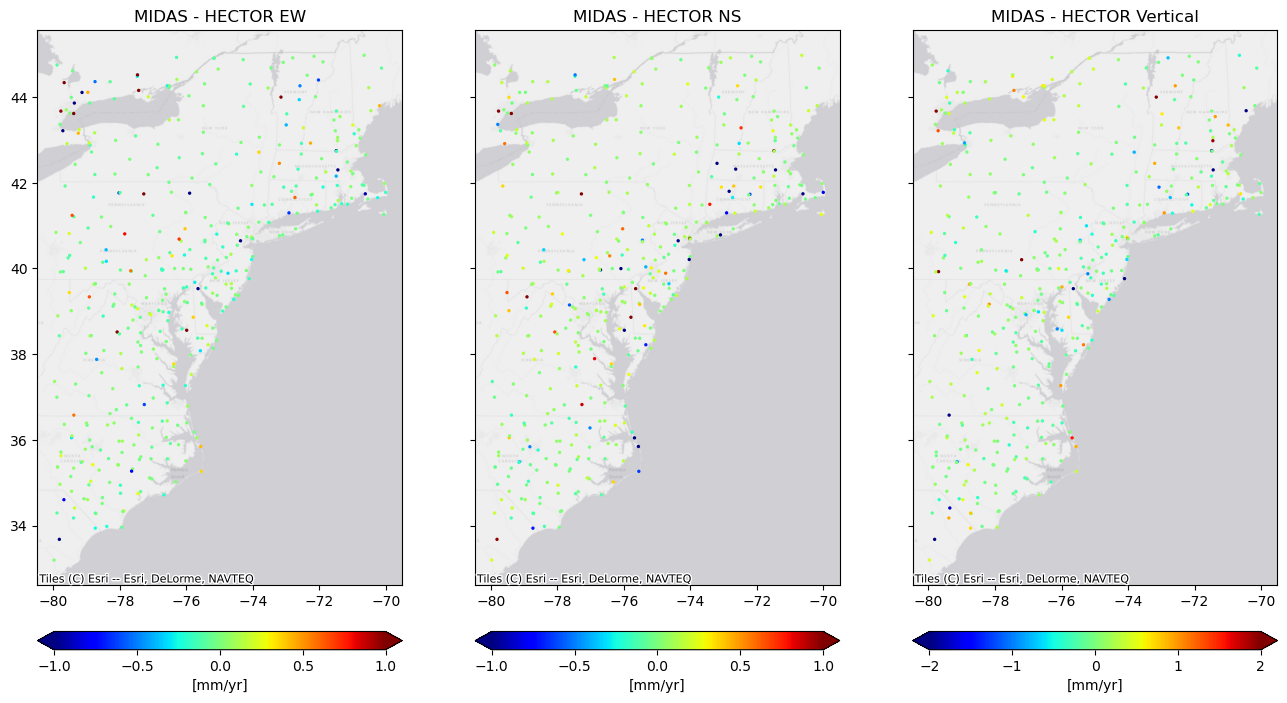

In [ ]:
kwargs =dict(markersize=2, cmap='jet', zorder=1)
kwargs['cmap'] = 'jet'
fig, ax = plt.subplots(1, 3, figsize=(16,12), sharey=True)
im1 = df_dif.plot(ax=ax[0], column='diff_e', vmin=-1, vmax=1, **kwargs)
im2 = df_dif.plot(ax=ax[1], column='diff_n', vmin=-1, vmax=1, **kwargs)
im3 = df_dif.plot(ax=ax[2], column='diff_v',vmin=-2, vmax=2, **kwargs)
for a, txt in zip(ax, ['MIDAS - HECTOR EW', 'MIDAS - HECTOR NS', 'MIDAS - HECTOR Vertical']): a.set_title(txt)
for a, im in zip(ax, [im1, im2, im3]): 
    fig.colorbar(im.collections[0], ax=a.axes, 
                 location='bottom', pad=0.05, 
                 extend='both', label='[mm/yr]')

# plot plates
for a in ax:
    #plates.plot(ax=a, lw=1, color='black',zorder=2)
    cx.add_basemap(a, zoom=7,
                   source=cx.providers.Esri.WorldGrayCanvas, 
                   crs='EPSG:4326')

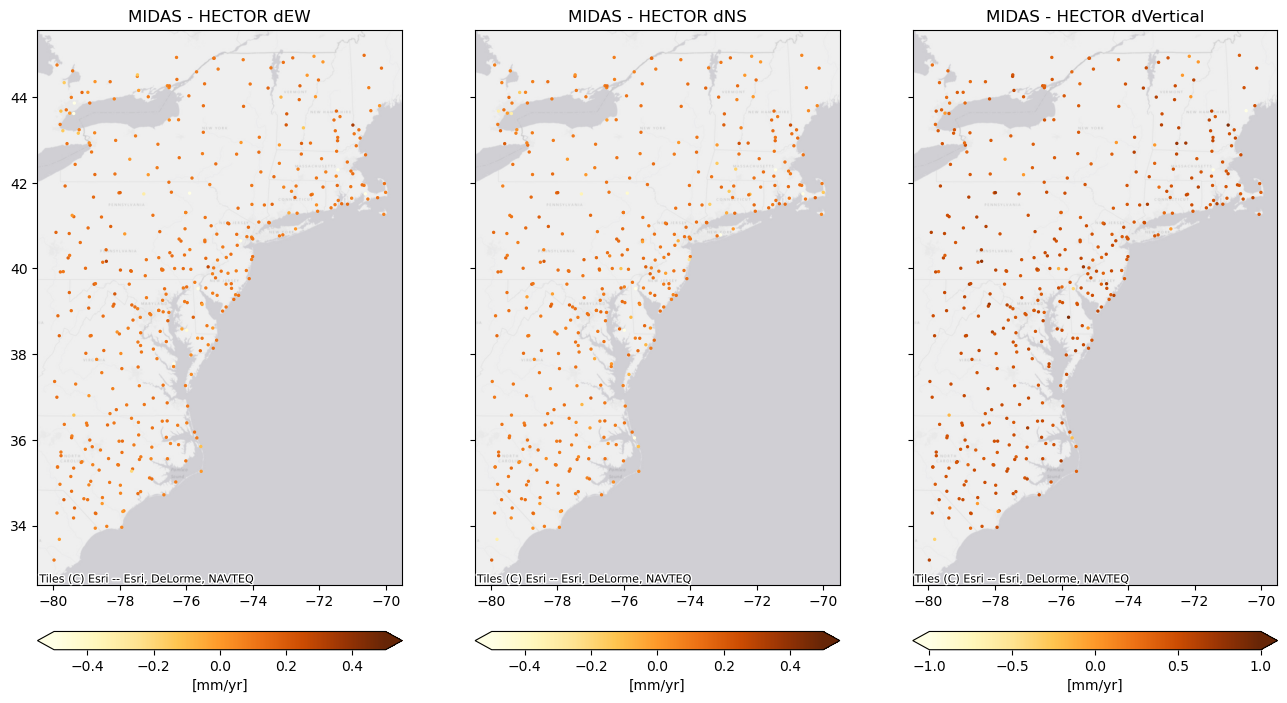

In [ ]:
kwargs['cmap'] = 'YlOrBr'
fig, ax = plt.subplots(1, 3, figsize=(16,12), sharey=True)
im1 = df_dif.plot(ax=ax[0], column='diff_se', vmin=-0.5, vmax=0.5, **kwargs)
im2 = df_dif.plot(ax=ax[1], column='diff_sn', vmin=-0.5, vmax=0.5, **kwargs)
im3 = df_dif.plot(ax=ax[2], column='diff_sv',vmin=-1.0, vmax=1.0, **kwargs)
for a, txt in zip(ax, ['MIDAS - HECTOR dEW', 'MIDAS - HECTOR dNS', 'MIDAS - HECTOR dVertical']): a.set_title(txt)
for a, im in zip(ax, [im1, im2, im3]): 
    fig.colorbar(im.collections[0], ax=a.axes, 
                 location='bottom', pad=0.05, 
                 extend='both', label='[mm/yr]')

# plot plates
for a in ax:
    #plates.plot(ax=a, lw=1, color='black',zorder=2
    cx.add_basemap(a, zoom=7,
                   source=cx.providers.Esri.WorldGrayCanvas, 
                   crs='EPSG:4326')

In [ ]:
from scipy import stats

(array([  1.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.,   1.,   4., 298., 102.,   3.]),
 array([-34.76839903, -32.82699163, -30.88558423, -28.94417683,
        -27.00276943, -25.06136204, -23.11995464, -21.17854724,
        -19.23713984, -17.29573244, -15.35432504, -13.41291764,
        -11.47151024,  -9.53010285,  -7.58869545,  -5.64728805,
         -3.70588065,  -1.76447325,   0.17693415,   2.11834155,
          4.05974895]),
 <BarContainer object of 20 artists>)

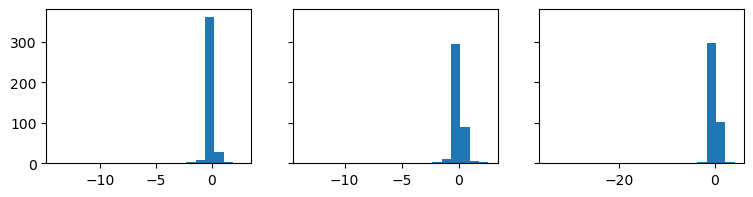

In [ ]:
fig, ax = plt.subplots(1,3,sharey=True, figsize=(9,2))
ax[0].hist(df_dif.diff_e, bins=20)
ax[1].hist(df_dif.diff_n, bins=20)
ax[2].hist(df_dif.diff_v, bins=20)